# Modelling a simple RNA circuit

In this notebook, an example

In [1]:
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.utils.common.setup import construct_circuit_from_cfg, prepare_config
from synbio_morpher.utils.circuit.agnostic_circuits.circuit_manager import CircuitModeller
from synbio_morpher.utils.modelling.physical import equilibrium_constant_reparameterisation, eqconstant_to_rates


In [ ]:
import synbio_morpher.utils.common.configs.RNA_circuit.molecular_params

In [2]:
config = {}
config = {
    "data_path": "data/example/toy_mRNA_circuit.fasta",
    "experiment": {
        "purpose": "example"
    },
    "interaction_simulator": {
        "name": "IntaRNA",
        "postprocess": True
    },
    "molecular_params": "synbio_morpher/utils/common/configs/RNA_circuit/molecular_params.json",
    "simulation": {
        "dt": 0.01,
        "t0": 0,
        "t1": 500,
        "solver": "diffrax"
    },
    "signal": {
        "inputs": ["RNA_0"],
        "outputs": ["RNA_1"],
        "function_name": "step_function",
        "function_kwargs": {
            "impulse_center": 40, 
            "impulse_halfwidth": 5, 
            "target": 0.5
        } 
    },
    "system_type": "RNA"
}

config, data_writer = script_preamble(config=config, data_writer=None, alt_cfg_filepath=None)
config = prepare_config(config)

# Add fake interactions
fake_interactions = np.random.randint(-50, 0, (3,3))
config["interactions"] = {
    "energies": fake_interactions,
    "eqconstants": equilibrium_constant_reparameterisation(fake_interactions, initial=100),
    "binding_rates_dissociation": eqconstant_to_rates(equilibrium_constant_reparameterisation(fake_interactions, initial=100), k_a=config['molecular_params']['association_binding_rate_per_molecule'])[0],
}
config["interactions"]

{'energies': array([[-29, -48, -32],
        [-49,  -9, -15],
        [-19, -43, -34]]),
 'eqconstants': array([[3.99278684e+04, 1.59423467e+11, 4.40131935e+05],
        [3.54803451e+11, 4.49328964e-03, 5.45981500e-01],
        [1.33943076e+01, 2.91994265e+09, 2.17998775e+06]]),
 'binding_rates_dissociation': array([[0.00150958, 0.00150958, 0.00150958],
        [0.00150958, 0.00150958, 0.00150958],
        [0.00150958, 0.00150958, 0.00150958]])}

In [3]:
circuit = construct_circuit_from_cfg(config_file=config, prev_configs=None)
circuit.__dict__

xla_bridge.py:backends():355: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker:  INFO
xla_bridge.py:backends():355: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Host CUDA Interpreter INFO
xla_bridge.py:backends():355: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client' INFO
xla_bridge.py:backends():355: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this. INFO


{'name': 'toy_mRNA_circuit',
 'subname': 'ref_circuit',
 'result_collector': <src.utils.results.results.ResultCollector at 0x7f2421fd3fa0>,
 'use_prod_and_deg': True,
 'model': MedModel(species=[Species: ('RNA_0', 'RNA_0'), Species: ('RNA_0', 'RNA_1'), Species: ('RNA_0', 'RNA_2'), Species: ('RNA_1', 'RNA_1'), Species: ('RNA_1', 'RNA_2'), Species: ('RNA_2', 'RNA_2'), Species: RNA_0, Species: RNA_1, Species: RNA_2], reactions=[Reaction(input=[Species: RNA_0], output=[], forward_rate=0.01175, reverse_rate=0), Reaction(input=[Species: RNA_1], output=[], forward_rate=0.01175, reverse_rate=0), Reaction(input=[Species: RNA_2], output=[], forward_rate=0.01175, reverse_rate=0), Reaction(input=[Species: ('RNA_0', 'RNA_0')], output=[], forward_rate=0.01175, reverse_rate=0), Reaction(input=[Species: ('RNA_0', 'RNA_1')], output=[], forward_rate=0.01175, reverse_rate=0), Reaction(input=[Species: ('RNA_0', 'RNA_2')], output=[], forward_rate=0.01175, reverse_rate=0), Reaction(input=[Species: ('RNA_1',

In [4]:

modeller = CircuitModeller(result_writer=data_writer, config=config)
circuit = modeller.init_circuit(circuit=circuit)
modeller
circuit = modeller.simulate_signal_batch(circuits=[circuit], ref_circuit=circuit)[0]
modeller.write_results(circuit)

print('\nData output written to ', modeller.result_writer.write_dir)


simulator.py:check_IntaRNA_path():106: Could not detect IntaRNA on system: CompletedProcess(args='which IntaRNA', returncode=1, stdout='', stderr='') WARNING


Done:  0:00:04.669557


circuit_manager.py:simulate_signal_batch():346: 		Simulating signal took 5.108228s WARNING


Done:  0:00:05.082752


circuit_manager.py:simulate_signal_batch():409: 		Calculating analytics took 3.589372s WARNING



Data output written to  ./data/example/2023_06_14_172348


## Plot the dynamics

In [5]:
circuit.result_collector.results.keys()

dict_keys(['steady_states', 'signal'])

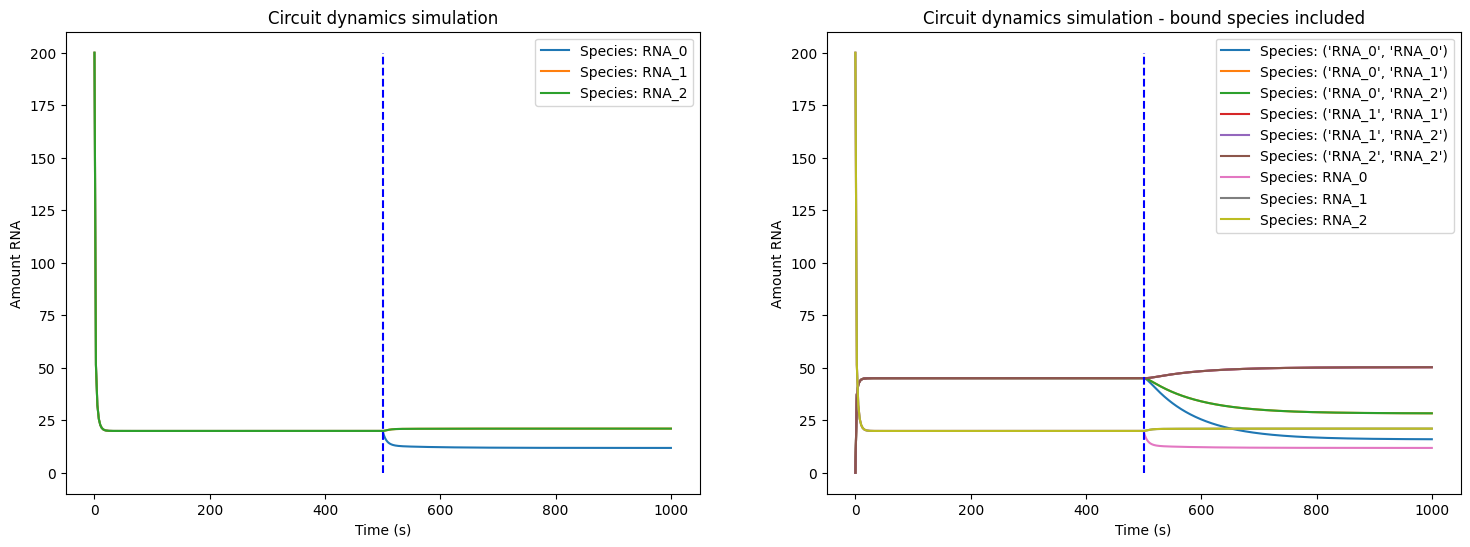

In [6]:

result1 = circuit.result_collector.results['steady_states']
result2 = circuit.result_collector.results['signal']

plt.figure(figsize=(18, 6))
ax = plt.subplot(1,2,1)

d1 = result1.data[-3:]
d2 = result2.data[-3:]
t1 = np.expand_dims(result1.vis_kwargs['t'], axis=0)
t2 = np.expand_dims(result2.vis_kwargs['t'], axis=0)
plt.plot(np.repeat(np.concatenate([t1, t1.max() + t2], axis=1), repeats=d1.shape[0], axis=0).T, np.concatenate([d1.T, d2.T]))
plt.plot([t1.max(), t1.max()], [0, result1.data.max()], 'b--')
plt.title('Circuit dynamics simulation')
plt.xlabel('Time (s)')
plt.ylabel('Amount RNA')
plt.legend(circuit.model.species[-3:])


ax = plt.subplot(1,2,2)

d1 = result1.data
d2 = result2.data
t1 = np.expand_dims(result1.vis_kwargs['t'], axis=0)
t2 = np.expand_dims(result2.vis_kwargs['t'], axis=0)
plt.plot(np.repeat(np.concatenate([t1, t1.max() + t2], axis=1), repeats=d1.shape[0], axis=0).T, np.concatenate([d1.T, d2.T]))
plt.plot([t1.max(), t1.max()], [0, result1.data.max()], 'b--')
plt.title('Circuit dynamics simulation - bound species included')
plt.xlabel('Time (s)')
plt.ylabel('Amount RNA')
plt.legend(circuit.model.species)

For a more in-depth explanation, look at the notebooks in the `explanations` directory!